In [259]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold

import sys
sys.path.insert(0, '../models/') #need this in order to get to the other file in other directory

from simpleModel import SimpleNeuralNet

#can comment out the ones you aren't using to save a little bit of time
from covidPreprocess import getCoronaVocabulary, get_whole_Corona_dataset, getCoronaText
from liarPreprocess import getLiarVocabulary, getLiarText
from fnnPreprocess import getFNNVocabulary, getFNNText

import torch
import torch.nn as nn

In [260]:
def train_simple_model_with_data(train_loader, vocabsize, num_epochs = 5, learning_rate = 0.001, print_epoch_mod = 5, DEBUG_MODE = False):
    '''
    train with the given dataset
    
    used this article for help in writing the tensor parts of code so it works with the model
    https://medium.com/analytics-vidhya/part-1-sentiment-analysis-in-pytorch-82b35edb40b8
    '''

    torch.manual_seed(1)
    
    #sample test on logistic classifier
    '''classifier = LogisticRegression()
    classifier.fit(X_train,Y_train)
    score = classifier.score(x_test,Y)
    print(score)'''

    device = torch.device("cpu")

    
    #initialize our model
    model = SimpleNeuralNet(vocabsize, 200, 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    
    
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (x_batch, labels) in enumerate(train_loader):
    
            # Forward pass
            # The forward process computes the loss of each iteration on each sample
            model.train()
            y_pred = model(x_batch)
            #need to transform labels to long datatype using .long() or it complains it's an int
            loss = criterion(y_pred, labels.long())
    
            # Backward pass, using the optimizer to update the parameters
            optimizer.zero_grad()
            loss.backward()    #compute gradients
            optimizer.step()   #initiate gradient descent
    
     
            # Below, an epoch corresponds to one pass through all of the samples.
            # Each training step corresponds to a parameter update using 
            # a gradient computed on a minibatch of 100 samples
            if DEBUG_MODE:
                if (i + 1) % print_epoch_mod == 0: 
                    # leaving it on 5 for corona dataset, probably want to change to % 50 or % 100
                    # for the other datasets so don't get spammed 
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

    return model

In [261]:
def get_model_accuracy(train_loader, test_loader, model, debug=False):
    # Test the model
    # In the test phase, we don't need to compute gradients (the model has already been learned)
    train_accuracy = 0
    test_accuracy = 0
    k = 5

    with torch.no_grad():
        total = 0
        correct = 0

        for data, labels in train_loader:
            if debug:
                print('data:', data)
                print('data shape:', data.shape) # size of train data set
                print('label:', labels)
                print('label shape:', labels.shape)

            outputs = model(data)
            
            if debug:
                print('outputs:', outputs)
                print('outputs data:', outputs.data)

            _, predicted = torch.max(outputs.data, 1)

            if debug:
                print('predicted:', predicted)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if debug:
                print('label size:', labels.size(0))
                print('correct labels:', (predicted == labels).sum().item())
                break

        train_accuracy = correct / total

        total = 0
        correct = 0

        for data, labels in test_loader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total

        if debug:
            print("train accuracy: {:.4f}%".format(train_accuracy * 100))
            print("test accuracy: {:.4f}%".format(test_accuracy * 100))
            print("difference in accuracies: {:.4f}%".format(abs(test_accuracy - train_accuracy) * 100))

        return train_accuracy, test_accuracy

In [262]:
def chart_epoch_diff(*args_list, debug=False):
    X, Y, vectorizer_train = get_whole_Corona_dataset()
    X = X.todense()
    Y = np.array(Y)

    if debug:
        print('X:', X.shape, type(X))
        print('Y:', Y.shape, type(Y))

    
    # X,Y = getLiarText()
    # X_train,Y_train, vectorizer_train = getLiarVocabulary(True)
    # X,Y = getFNNText()
    # X_train,Y_train, vectorizer_train = getFNNVocabulary(True)
    
    #transform our testing dataset to match the vocabulary for the training dataset
    #transform will return the document-term matrix for X based on training dataset
    # print('X type:', type(X))
    # print('X:', X)
    # print('Y type:', type(Y))
    # print('Y:', Y)

    numFold = 5
    epoch_list = np.array([5, 10, 25, 50, 100])

    total_train_acc_list = []
    total_test_acc_list = []

    for n_epoch in epoch_list:
        print('beginning a test for', n_epoch, "epoches")
        skf = StratifiedKFold(n_splits=numFold)
        skf.get_n_splits(X, Y)

        total_train_acc = 0
        total_test_acc = 0
        
        for i, (train_ind, test_ind) in enumerate(skf.split(X, Y), start=1):
            X_train, X_test = X[train_ind], X[test_ind]
            Y_train, Y_test = Y[train_ind], Y[test_ind]

            if debug:
                print('X train shape:', X_train.shape)
                print('X test shape:', X_test.shape)
                print('Y train shape:', Y_train.shape)
                print('Y test shape:', Y_test.shape)

            # transform our training and test data into tensors for the classifier to learn off of
            X_train_tensor = torch.from_numpy(X_train).float()
            Y_train_tensor = torch.from_numpy(Y_train)
            X_test_tensor = torch.from_numpy(X_test).float()
            Y_test_tensor = torch.from_numpy(Y_test)
            
            device = torch.device("cpu")
            # use TensorDataset to be able to use our DataLoader
            train_data = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
            train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=False)
            test_data = torch.utils.data.TensorDataset(X_test_tensor, Y_test_tensor)
            test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

            vocabsize = X_train.shape[1]

            model = train_simple_model_with_data(train_loader, vocabsize, num_epochs=n_epoch)
            train_acc, test_acc = get_model_accuracy(train_loader, test_loader, model)

            total_train_acc += train_acc
            total_test_acc += test_acc

            if debug:
                print(i, '-Fold:', sep='')
                print("train accuracy: {:.4f}%".format(train_acc * 100))
                print("test accuracy: {:.4f}%".format(test_acc * 100))
                print("difference in accuracies: {:.4f}%".format(abs(test_acc - train_acc) * 100))

        total_train_acc /= numFold
        total_test_acc /= numFold

        total_train_acc_list.append(total_train_acc)
        total_test_acc_list.append(total_test_acc)

        if debug:
            print("final train accuracy: {:.4f}%".format(total_train_acc * 100))
            print("final test accuracy: {:.4f}%".format(total_test_acc * 100))

    if debug:
        print("tr:", total_train_acc_list)
        print("te:", total_test_acc_list)

    total_train_acc_list = np.array(total_train_acc_list) * 100
    total_test_acc_list = np.array(total_test_acc_list) * 100

    plt_data = pd.DataFrame({'Number of Epoch': epoch_list, 'Train Accuracy': total_train_acc_list, \
                             'Test Accuracy': total_test_acc_list})
    plt.plot('Number of Epoch', 'Train Accuracy', data=plt_data, marker='.', markerfacecolor='skyblue', markersize=10, color='skyblue', linewidth=2)
    plt.plot('Number of Epoch', 'Test Accuracy', data=plt_data, marker='.', markerfacecolor='olive', markersize=10, color='olive', linewidth=2)
    plt.xlabel('Number of Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

beginning a test for 5 epoches
beginning a test for 10 epoches
beginning a test for 25 epoches
beginning a test for 50 epoches
beginning a test for 100 epoches


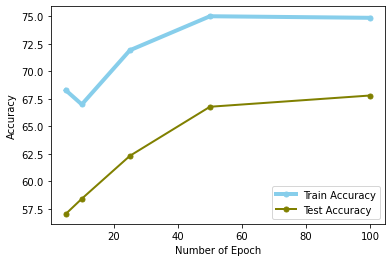

In [263]:
chart_epoch_diff()